In [1]:
!pip install transformers datasets keras tensorflow sentencepiece prettytable seqeval[gpu]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 55.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 44.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 66.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━

In [6]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [2]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


#Overwrite Base Config/Model

In [3]:
from transformers.models.xlm_roberta import XLMRobertaPreTrainedModel, XLMRobertaModel
from transformers.models.roberta import RobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
import torch
from torch import nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss, BCELoss
from typing import List, Optional, Tuple, Union


from transformers import PretrainedConfig


class XLMRobertaRefSegConfig(PretrainedConfig):
    r"""
    This is the configuration class to store the configuration of a [`XLMRobertaModel`] or a [`TFXLMRobertaModel`]. It
    is used to instantiate a XLM-RoBERTa model according to the specified arguments, defining the model architecture.
    Instantiating a configuration with the defaults will yield a similar configuration to that of the XLMRoBERTa
    [xlm-roberta-base](https://huggingface.co/xlm-roberta-base) architecture.
    Configuration objects inherit from [`PretrainedConfig`] and can be used to control the model outputs. Read the
    documentation from [`PretrainedConfig`] for more information.
    Args:
        vocab_size (`int`, *optional*, defaults to 30522):
            Vocabulary size of the XLM-RoBERTa model. Defines the number of different tokens that can be represented by
            the `inputs_ids` passed when calling [`XLMRobertaModel`] or [`TFXLMRobertaModel`].
        hidden_size (`int`, *optional*, defaults to 768):
            Dimensionality of the encoder layers and the pooler layer.
        num_hidden_layers (`int`, *optional*, defaults to 12):
            Number of hidden layers in the Transformer encoder.
        num_attention_heads (`int`, *optional*, defaults to 12):
            Number of attention heads for each attention layer in the Transformer encoder.
        intermediate_size (`int`, *optional*, defaults to 3072):
            Dimensionality of the "intermediate" (often named feed-forward) layer in the Transformer encoder.
        hidden_act (`str` or `Callable`, *optional*, defaults to `"gelu"`):
            The non-linear activation function (function or string) in the encoder and pooler. If string, `"gelu"`,
            `"relu"`, `"silu"` and `"gelu_new"` are supported.
        hidden_dropout_prob (`float`, *optional*, defaults to 0.1):
            The dropout probability for all fully connected layers in the embeddings, encoder, and pooler.
        attention_probs_dropout_prob (`float`, *optional*, defaults to 0.1):
            The dropout ratio for the attention probabilities.
        max_position_embeddings (`int`, *optional*, defaults to 512):
            The maximum sequence length that this model might ever be used with. Typically set this to something large
            just in case (e.g., 512 or 1024 or 2048).
        type_vocab_size (`int`, *optional*, defaults to 2):
            The vocabulary size of the `token_type_ids` passed when calling [`XLMRobertaModel`] or
            [`TFXLMRobertaModel`].
        initializer_range (`float`, *optional*, defaults to 0.02):
            The standard deviation of the truncated_normal_initializer for initializing all weight matrices.
        layer_norm_eps (`float`, *optional*, defaults to 1e-12):
            The epsilon used by the layer normalization layers.
        position_embedding_type (`str`, *optional*, defaults to `"absolute"`):
            Type of position embedding. Choose one of `"absolute"`, `"relative_key"`, `"relative_key_query"`. For
            positional embeddings use `"absolute"`. For more information on `"relative_key"`, please refer to
            [Self-Attention with Relative Position Representations (Shaw et al.)](https://arxiv.org/abs/1803.02155).
            For more information on `"relative_key_query"`, please refer to *Method 4* in [Improve Transformer Models
            with Better Relative Position Embeddings (Huang et al.)](https://arxiv.org/abs/2009.13658).
        is_decoder (`bool`, *optional*, defaults to `False`):
            Whether the model is used as a decoder or not. If `False`, the model is used as an encoder.
        use_cache (`bool`, *optional*, defaults to `True`):
            Whether or not the model should return the last key/values attentions (not used by all models). Only
            relevant if `config.is_decoder=True`.
        classifier_dropout (`float`, *optional*):
            The dropout ratio for the classification head.
    Examples:
    ```python
    >>> from transformers import XLMRobertaConfig, XLMRobertaModel
    >>> # Initializing a XLM-RoBERTa xlm-roberta-base style configuration
    >>> configuration = XLMRobertaConfig()
    >>> # Initializing a model (with random weights) from the xlm-roberta-base style configuration
    >>> model = XLMRobertaModel(configuration)
    >>> # Accessing the model configuration
    >>> configuration = model.config
    ```"""
    model_type = "xlm-roberta"

    def __init__(
            self,
            vocab_size=250002,
            hidden_size=768,
            num_hidden_layers=12,
            num_attention_heads=12,
            intermediate_size=3072,
            hidden_act="gelu",
            hidden_dropout_prob=0.1,
            attention_probs_dropout_prob=0.1,
            max_position_embeddings=514,
            type_vocab_size=1,
            initializer_range=0.02,
            layer_norm_eps=1e-12,
            pad_token_id=1,
            bos_token_id=0,
            eos_token_id=2,
            position_embedding_type="absolute",
            use_cache=True,
            classifier_dropout=None,
            num_labels_first=29,
            num_labels_second=2,
            alpha=1.0,
            **kwargs
        ):
            super().__init__(pad_token_id=pad_token_id, bos_token_id=bos_token_id, eos_token_id=eos_token_id, **kwargs)

            self.vocab_size = vocab_size
            self.hidden_size = hidden_size
            self.num_hidden_layers = num_hidden_layers
            self.num_attention_heads = num_attention_heads
            self.hidden_act = hidden_act
            self.intermediate_size = intermediate_size
            self.hidden_dropout_prob = hidden_dropout_prob
            self.attention_probs_dropout_prob = attention_probs_dropout_prob
            self.max_position_embeddings = max_position_embeddings
            self.type_vocab_size = type_vocab_size
            self.initializer_range = initializer_range
            self.layer_norm_eps = layer_norm_eps
            self.position_embedding_type = position_embedding_type
            self.use_cache = use_cache
            self.classifier_dropout = classifier_dropout
            self.num_labels_first = num_labels_first
            self.num_labels_second = num_labels_second
            self.alpha = alpha
            super().__init__(pad_token_id=pad_token_id, bos_token_id=bos_token_id, eos_token_id=eos_token_id, **kwargs)


class XLMRobertaForReferenceSegmentation(XLMRobertaPreTrainedModel):
    _keys_to_ignore_on_load_unexpected = [r"pooler"]
    _keys_to_ignore_on_load_missing = [r"position_ids"]

    def __init__(self, config):
        super().__init__(config)
        self.num_labels_first = config.num_labels_first
        self.num_labels_second = config.num_labels_second
        self.alpha = config.alpha

        self.roberta = XLMRobertaModel(config, add_pooling_layer=False)
        classifier_dropout = (
            config.classifier_dropout if config.classifier_dropout is not None else config.hidden_dropout_prob
        )
        self.dropout = nn.Dropout(classifier_dropout)
        self.classifier_first = nn.Linear(config.hidden_size, self.num_labels_first)
        self.classifier_second = nn.Linear(config.hidden_size, self.num_labels_second)

        self.post_init()

    def forward(
            self,
            input_ids: Optional[torch.LongTensor] = None,
            attention_mask: Optional[torch.FloatTensor] = None,
            token_type_ids: Optional[torch.LongTensor] = None,
            position_ids: Optional[torch.LongTensor] = None,
            head_mask: Optional[torch.FloatTensor] = None,
            inputs_embeds: Optional[torch.FloatTensor] = None,
            labels_first: Optional[torch.LongTensor] = None,
            labels_second: Optional[torch.LongTensor] = None,
            output_attentions: Optional[bool] = None,
            output_hidden_states: Optional[bool] = None,
            return_dict: Optional[bool] = None,
    ) -> Union[Tuple[torch.Tensor], TokenClassifierOutput]:
        r"""
        labels (`torch.LongTensor` of shape `(batch_size, sequence_length)`, *optional*):
            Labels for computing the token classification loss. Indices should be in `[0, ..., config.num_labels - 1]`.
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.roberta(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = outputs[0]

        sequence_output_first = self.dropout(sequence_output)
        logits_first = self.classifier_first(sequence_output_first)

        sequence_output_second = self.dropout(sequence_output)
        logits_second = self.classifier_second(sequence_output_second)

        loss = None
        if labels_first is not None and labels_second is not None:
            loss_fct_first = CrossEntropyLoss()
            loss_fct_second = CrossEntropyLoss()
            loss_first = loss_fct_first(logits_first.view(-1, self.num_labels_first), labels_first.view(-1))
            loss_second = loss_fct_second(logits_second.view(-1, self.num_labels_second), labels_second.view(-1))
            loss = loss_first + (self.alpha * loss_second)

        return TokenClassifierOutput(
            loss=loss,
            logits=[logits_first, logits_second],
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )



In [4]:
from transformers import XLMRobertaTokenizerFast, XLMRobertaTokenizer, AutoTokenizer
from tokenizers.pre_tokenizers import Whitespace
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
import torch
from torch.utils.data import Dataset, DataLoader
from tokenizers import pre_tokenizers
from tokenizers.pre_tokenizers import Digits, Split, Metaspace, Sequence

In [7]:
from datasets import load_dataset

dataset = load_dataset('GEOcite/ReferenceParserDataset')

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset ref_seg_ger downloaded and prepared to /root/.cache/huggingface/datasets/MrPotato___ref_seg_ger/default/1.0.0/71d78ec91c18c7e5b81314b14f8889c26c4a40b9f053291690f8a5f39c7447c3. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [10]:
id2label = {k:v for k,v in enumerate(dataset['train'].features['labels'].feature.names)}
label2id = {v:k for k,v in enumerate(dataset['train'].features['labels'].feature.names)}
id2label_ref = {k:v for k,v in enumerate(dataset['train'].features['labels_ref'].feature.names)}
label_ref2id = {v:k for k,v in enumerate(dataset['train'].features['labels_ref'].feature.names)}

In [12]:
dataset["train"][2]

{'id': 'Ga&S_2000_0003.xml.csv',
 'tokens': ['Bechmann',
  ',',
  'A',
  '.',
  ':',
  'Bewertungsverfahren',
  '-',
  'der',
  'handlungsbezogene',
  'Kern',
  'von',
  'Umweltverträglichkeitsprüfungen',
  '.',
  'In',
  ':',
  'Hübler',
  ',',
  'K',
  '.',
  '-',
  'H',
  '.',
  'u',
  '.',
  'K',
  '.',
  'Otto',
  '-',
  'Zimmermann',
  ':',
  'Bewertung',
  'der',
  'Umweltverträglichkeit',
  '.',
  'Taunusstein',
  ':',
  'Eberhard',
  'Blottner',
  ',',
  '1989',
  ',',
  'S',
  '.',
  '84',
  '-',
  '103',
  'Bechmann',
  ',',
  'A',
  '.',
  ':',
  'Grundlagen',
  'der',
  'Bewertung',
  'von',
  'Umweltauswirkungen',
  '.',
  'In',
  ':',
  'Storm',
  ',',
  'P',
  '.',
  '-',
  'Chr',
  '.',
  'und',
  'Th',
  '.',
  'Bunge',
  '(',
  'Hrsg',
  '.',
  ')',
  ':',
  'Handbuch',
  'der',
  'Umweltverträglichkeitsprüfung',
  '.',
  'Berlin',
  ':',
  'E',
  '.',
  'Schmidt',
  ',',
  '1988',
  'ff',
  'Bechmann',
  ',',
  'A',
  '.',
  ':',
  'Die',
  'Nutzwertanalyse',
  '.',

In [13]:
i = 2
from prettytable import PrettyTable
t = PrettyTable(['token', 'label', 'new_ref'])
for tkn, lbl, ref in zip(dataset["train"][i]["tokens"], dataset["train"][i]["labels"], dataset["train"][i]["labels_ref"]):
    t.add_row([tkn, id2label[lbl], id2label_ref[ref]])
print(t)

+---------------------------------+-------------+---------+
|              token              |    label    | new_ref |
+---------------------------------+-------------+---------+
|             Bechmann            |   B-author  |  B-ref  |
|                ,                |   I-author  |  I-ref  |
|                A                |   I-author  |  I-ref  |
|                .                |      O      |  I-ref  |
|                :                |      O      |  I-ref  |
|       Bewertungsverfahren       |   B-title   |  I-ref  |
|                -                |   I-title   |  I-ref  |
|               der               |   I-title   |  I-ref  |
|        handlungsbezogene        |   I-title   |  I-ref  |
|               Kern              |   I-title   |  I-ref  |
|               von               |   I-title   |  I-ref  |
| Umweltverträglichkeitsprüfungen |   I-title   |  I-ref  |
|                .                |      O      |  I-ref  |
|                In               |     

In [14]:
tokenizer = XLMRobertaTokenizerFast.from_pretrained("xlm-roberta-large")

In [22]:
import math
import numpy as np

def align_labels(words, text_labels, reference_labels, pad=-100, max_len=512, idx=None):
    word_labels = []
    ref_labels = []

    for word, word_label, ref_label in zip(words, text_labels, reference_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        #print(tokenized_word)
        n_subwords = len(tokenized_word)

        if n_subwords == 1:
            word_labels.extend([word_label])
            ref_labels.extend([ref_label])
        elif n_subwords > max_len:
            # faulty string, should be cleaned up
            return None, None
        else:
            word_labels.extend([word_label])
            word_labels.extend([pad] * (n_subwords - 1))
            ref_labels.extend([ref_label])
            ref_labels.extend([pad] * (n_subwords - 1))

    n_dim = math.ceil((len(word_labels))/max_len)
    n_dim = math.ceil(((n_dim*2) + len(word_labels))/max_len)
    n_pads = (n_dim * max_len) - (len(word_labels)) - (n_dim*2)

    word_labels.extend([pad] * n_pads)
    ref_labels.extend([pad] * n_pads)
    for x in range(0, (n_dim)*max_len, max_len):
        word_labels.insert(x, pad)
        word_labels.insert(x+max_len-1, pad)
        ref_labels.insert(x, pad)
        ref_labels.insert(x+max_len-1, pad)

    return (np.array([word_labels]).reshape((n_dim, max_len)), np.array([ref_labels]).reshape((n_dim, max_len)))

In [16]:
max_size = 512

In [17]:
def tokenize_dataset(sample):
    chunks_id, chunks_input_ids, chunks_word_labels, chunks_ref_labels, chunks_attention_mask = [], [], [], [], []
    for idx in range(len(sample["tokens"])):
        #print(sample["tokens"][idx])
        processed_word_labels, processed_ref_labels = align_labels(sample["tokens"][idx], sample["labels"][idx], sample["labels_ref"][idx], max_len=max_size, idx=sample["id"][idx])
        #print(processed_ref_labels)
        if processed_word_labels is None:
            continue

        processed = tokenizer(
            sample["tokens"][idx],
            is_split_into_words=True,
            max_length=max_size,
            padding="max_length",
            truncation=True,
            return_overflowing_tokens=True,
            return_attention_mask=True
        )

        for i, input_ids in enumerate(processed["input_ids"]):
            #print(len(input_ids), len(processed_word_labels[i]))
            assert(len(input_ids) == len(processed_word_labels[i]))
            chunks_id.append(sample["id"][idx])
            #chunks_dataset.append(sample["dataset"][idx])
            chunks_input_ids.append(input_ids)
            chunks_word_labels.append(processed_word_labels[i])
            chunks_ref_labels.append(processed_ref_labels[i])
            chunks_attention_mask.append(processed["attention_mask"][i])
    return {
        "id": chunks_id,
        "input_ids": chunks_input_ids,
        "labels": chunks_word_labels,
        "labels_ref": chunks_ref_labels,
        "attention_mask": chunks_attention_mask,
        }

In [18]:
tokenized_dataset = dataset.map(tokenize_dataset, batched=True, remove_columns=dataset["train"].column_names)

Map:   0%|          | 0/373 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

In [20]:
tokenized_dataset["test"]

Dataset({
    features: ['id', 'labels', 'labels_ref', 'input_ids', 'attention_mask'],
    num_rows: 247
})

In [23]:
MAX_LEN = 512
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 2
EPOCHS = 2
LEARNING_RATE = 5e-05
MAX_GRAD_NORM = 10

In [24]:
class DataCollator(Dataset):
  def __init__(self, dataframe, tokenizer, max_len, split):
        self.len = len(dataframe[split])
        self.data = dataframe[split]
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.split = split

  def __getitem__(self, index):
        # step 1: get the sentence and word labels

        #sentence = ' '.join(self.data['input_ids'][index])
        #word_labels = self.data['labels'][index]
        #ref_labels = self.data['labels_ref'][index]


        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        #encoding = self.tokenizer(self.data['input_ids'][index],
        #                     is_split_into_words=True,
        #                     return_offsets_mapping=True,
        #                     padding='max_length',
        #                     truncation=True,
        #                     max_length=self.max_len)
        #print(len(encoding['offset_mapping']))
        # step 3: create token labels only for first word pieces of each tokenized word
        #labels = [label2id[label] for label in word_labels]
        # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
        # create an empty array of -100 of length max_length
        #encoded_labels = np.ones(len(encoding["input_ids"]), dtype=int) * -100
        #encoded_labels_ref = np.ones(len(encoding["input_ids"]), dtype=int) * -100

        # set only labels whose first offset position is 0 and the second is not 0
        # i = 0
        # for idx, (start, end) in enumerate(encoding["offset_mapping"]):
        #     #print(idx)
        #     # new token
        #     if start == 0 and end != 0:

        #         encoded_labels[idx] = word_labels[i]
        #         encoded_labels_ref[idx] = ref_labels[i]
        #         if encoding["input_ids"][idx] != 6:
        #             i += 1
        #     elif start != 0 and end != 0:
        #     # overwrite label
        #         pass
        #         #encoded_labels[idx] = word_labels[i-1]


        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in self.data[index].items() if key!="id"}
        #item['labels'] = torch.as_tensor(encoded_labels)
        #item['labels_ref'] = torch.as_tensor(encoded_labels_ref)

        return item

  def __len__(self):
        return self.len

In [25]:
training_set = DataCollator(tokenized_dataset, tokenizer, MAX_LEN, 'train')
testing_set = DataCollator(tokenized_dataset, tokenizer, MAX_LEN, 'test')

In [ ]:
training_set[0]

{'labels': tensor([-100,    8, -100, -100,    9,   26, -100,    6,    7,    7, -100,   26,
           16,   26,   26, -100,   20,   21,   21,   26, -100,    6,   26, -100,
           26,    4,    5,    5,    5,    5, -100,    5, -100,    5, -100,    5,
            5,    5, -100,    8, -100, -100,    9,   26, -100,   26,   16,   26,
           26, -100,   20, -100,   21,   21, -100, -100, -100,   21, -100, -100,
           21, -100,   21, -100,   21, -100, -100, -100,   21, -100,   21, -100,
           21, -100,   21,   21, -100,   26, -100,    6,   26, -100,    8, -100,
         -100,    9,   26, -100,   26,   16,   26,   26, -100,   20, -100,   21,
         -100,   21, -100,   21, -100,   21,   21,   21,   21,   21,   26, -100,
            6, -100,   26, -100,    8, -100, -100,    9,   26, -100,   26,   16,
           26,   26, -100,   20, -100,   21, -100,   21,   21,   21, -100,   26,
         -100,   26,   26,   10, -100,   11,   11, -100,   26, -100,   10, -100,
         -100,   1

In [33]:
for token, label in zip(tokenizer.convert_ids_to_tokens(training_set[0]["input_ids"]), training_set[0]["labels"]):
  print('{0:10},{1}'.format(token, id2label[label.item()] if label != -100 else -100))

<s>       ,-100
▁Ben      ,B-author
nett      ,-100
▁         ,I-author
,         ,-100
▁W        ,I-author
▁         ,I-author
.         ,-100
▁L        ,I-author
▁         ,I-author
.         ,-100
▁(        ,O
▁2004     ,B-year
▁)        ,O
▁         ,O
.         ,-100
▁Global   ,B-title
▁Media    ,I-title
▁and      ,I-title
▁Politic  ,I-title
s         ,-100
▁:        ,I-title
▁Trans    ,I-title
national  ,-100
▁Communication,I-title
▁Regi     ,I-title
mes       ,-100
▁and      ,I-title
▁Civic    ,I-title
▁Culture  ,I-title
s         ,-100
▁         ,O
.         ,-100
▁Annu     ,B-source
al        ,-100
▁Review   ,I-source
▁of       ,I-source
▁Political,I-source
▁Science  ,I-source
▁         ,O
,         ,-100
▁7        ,B-volume
▁(        ,O
▁1        ,B-issue
▁)        ,O
▁         ,O
,         ,-100
▁125      ,B-fpage
▁-        ,O
▁148      ,B-lpage
▁         ,O
.         ,-100
▁do       ,B-other
i         ,-100
▁:        ,I-other
▁10       ,I-other
▁         ,I-other
.         

In [ ]:
labels = [
    'publisher', 'source', 'url', 'other', 'author', 'editor', 'lpage',
    'volume', 'year', 'issue', 'title', 'fpage', 'edition'
]

In [ ]:
id2label

{0: 'B-publisher',
 1: 'I-publisher',
 2: 'B-source',
 3: 'I-source',
 4: 'B-url',
 5: 'I-url',
 6: 'B-other',
 7: 'I-other',
 8: 'B-author',
 9: 'I-author',
 10: 'B-editor',
 11: 'I-editor',
 12: 'B-lpage',
 13: 'I-lpage',
 14: 'B-volume',
 15: 'I-volume',
 16: 'B-year',
 17: 'I-year',
 18: 'B-issue',
 19: 'I-issue',
 20: 'B-title',
 21: 'I-title',
 22: 'B-fpage',
 23: 'I-fpage',
 24: 'B-edition',
 25: 'I-edition',
 26: 'O'}

In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [ ]:
config_large = XLMRobertaRefSegConfig(alpha=0.5,
                                      num_labels_first=len(id2label),
                                      num_labels_second=len(id2label_ref),
                                      hidden_size=1024,
                                      intermediate_size=4096,
                                      num_attention_heads=16,
                                      num_hidden_layers=24,
                                      )

config = XLMRobertaRefSegConfig(alpha=0.5, num_labels_first=len(id2label), num_labels_second=2)
model = XLMRobertaForReferenceSegmentation.from_pretrained('xlm-roberta-large', config=config_large)
                                                   #id2label=id2label,
                                                   #label2id=label2id)

Some weights of XLMRobertaForReferenceSegmentation were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier_first.bias', 'classifier_second.weight', 'classifier_first.weight', 'classifier_second.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.to(device)

XLMRobertaForReferenceSegmentation(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=1024, out_fea

In [ ]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

In [ ]:
# Defining the training function on the 80% of the dataset for tuning the bert model
def train(epoch):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels_seg, tr_labels_ref = [], [], []
    # put model in training mode
    model.train()

    for idx, batch in enumerate(training_loader):

        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels_seg = batch['labels'].to(device, dtype = torch.long)
        labels_ref = batch['labels_ref'].to(device, dtype = torch.long)

        output = model(input_ids=ids, attention_mask=mask, labels_first=labels_seg, labels_second=labels_ref)
        #print(output)
        #output_seg = output[0]
        #output_ref = output[1]

        #tr_logits_seg = output[1][0]
        #tr_logits_ref = output[1][1]
        loss = output[0]
        tr_loss += loss.item()


        # loss = output_ref[0]
        # tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels_seg.size(0)

        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")

        # compute training accuracy
        #flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        #active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        #flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)

        # only compute accuracy at active labels
        #active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))

        #labels = torch.masked_select(flattened_targets, active_accuracy)
        #predictions = torch.masked_select(flattened_predictions, active_accuracy)

        #tr_labels.extend(labels)
        #tr_preds.extend(predictions)

        #tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        #tr_accuracy += tmp_tr_accuracy

        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    #tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    #print(f"Training accuracy epoch: {tr_accuracy}")

In [ ]:
for epoch in range(EPOCHS):
    print(f"Training epoch: {epoch + 1}")
    train(epoch)

In [ ]:
def valid(model, testing_loader):
    # put model in evaluation mode
    model.eval()

    eval_loss, eval_f1_seg, eval_f1_ref = 0, 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds_seg, eval_labels_seg = [], []
    eval_preds_ref, eval_labels_ref = [], []

    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):

            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels_seg = batch['labels'].to(device, dtype = torch.long)
            labels_ref = batch['labels_ref'].to(device, dtype = torch.long)

            output = model(input_ids=ids, attention_mask=mask, labels_first=labels_seg, labels_second=labels_ref)
            eval_logits_seg = output[1][0]
            eval_logits_ref = output[1][1]
            loss = output[0]

            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels_seg.size(0)

            if idx % 100==0:
                loss_step = eval_loss/nb_eval_steps
                print(f"Validation loss per 100 evaluation steps: {loss_step}")

            # compute evaluation accuracy
            flattened_targets_seg = labels_seg.view(-1) # shape (batch_size * seq_len,)
            flattened_targets_ref = labels_ref.view(-1)
            active_logits_seg = eval_logits_seg.view(-1, len(id2label)) # shape (batch_size * seq_len, num_labels)
            active_logits_ref = eval_logits_ref.view(-1, len(id2label_ref))
            flattened_predictions_seg = torch.argmax(active_logits_seg, axis=1)
            flattened_predictions_ref = torch.argmax(active_logits_ref, axis=1) # shape (batch_size * seq_len,)

            # only compute accuracy at active labels
            active_accuracy_seg = labels_seg.view(-1) != -100 # shape (batch_size, seq_len)
            active_accuracy_ref = labels_ref.view(-1) != -100 # shape (batch_size, seq_len)

            labels_seg = torch.masked_select(flattened_targets_seg, active_accuracy_seg)
            labels_ref = torch.masked_select(flattened_targets_ref, active_accuracy_ref)
            predictions_seg = torch.masked_select(flattened_predictions_seg, active_accuracy_seg)
            predictions_ref = torch.masked_select(flattened_predictions_ref, active_accuracy_ref)

            eval_labels_seg.append(labels_seg)
            eval_labels_ref.append(labels_ref)
            eval_preds_seg.append(predictions_seg)
            eval_preds_ref.append(predictions_ref)

            eval_f1_seg += f1_score(labels_seg.cpu().numpy(), predictions_seg.cpu().numpy(), average='micro')
            eval_f1_ref += f1_score(labels_ref.cpu().numpy(), predictions_ref.cpu().numpy(), average='micro')

    labels_seg = []
    for l in eval_labels_seg:
        inner_l = []
        for j in l:
            inner_l.append(id2label[j.item()])
        labels_seg.append(inner_l)
    predictions_seg = []
    for l in eval_preds_seg:
        inner_l = []
        for j in l:
            inner_l.append(id2label[j.item()])
        predictions_seg.append(inner_l)

    labels_ref = []
    for l in eval_labels_ref:
        inner_l = []
        for j in l:
            inner_l.append(id2label_ref[j.item()])
        labels_ref.append(inner_l)
    predictions_ref = []
    for l in eval_preds_ref:
        inner_l = []
        for j in l:
            inner_l.append(id2label_ref[j.item()])
        predictions_ref.append(inner_l)
    #labels = [[id2label[j.item()] for j in id] id in eval_labels]
    #labels = [id2label[id.item()] for id in eval_labels]
    #predictions = [id2label[id.item()] for id in eval_preds]

    eval_loss = eval_loss / nb_eval_steps
    eval_f1_seg = eval_f1_seg / nb_eval_steps
    eval_f1_ref = eval_f1_ref / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation F1 Segmentation: {eval_f1_seg}")
    print(f"Validation F1 Ref Seg: {eval_f1_ref}")

    return [(labels_seg, predictions_seg), (labels_ref, predictions_ref)]

In [ ]:
seg, ref = valid(model, testing_loader)

Validation loss per 100 evaluation steps: 0.09381772577762604
Validation loss per 100 evaluation steps: 0.15842568369047477
Validation Loss: 0.15417701022459135
Validation F1 Segmentation: 0.9594966920281386
Validation F1 Ref Seg: 0.9986486825886561


In [ ]:
from sklearn import metrics
from sklearn.metrics import classification_report
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
from tqdm.auto import tqdm
from glob import glob

In [ ]:
from seqeval.metrics import classification_report, performance_measure

print(classification_report(seg[0], seg[1]))
print(classification_report(ref[0], ref[1]))
print('######################################################')

              precision    recall  f1-score   support

      author       0.89      0.89      0.89      4106
      editor       0.89      0.90      0.89       421
       fpage       0.98      0.98      0.98      1188
       issue       0.81      0.89      0.85       267
       lpage       0.98      0.99      0.98      1109
       other       0.77      0.82      0.79       789
   publisher       0.80      0.90      0.84       344
      source       0.85      0.87      0.86      1456
       title       0.86      0.88      0.87      1992
         url       0.88      0.94      0.91        47
      volume       0.95      0.93      0.94      1038
        year       0.97      0.99      0.98      1935

   micro avg       0.90      0.91      0.91     14692
   macro avg       0.89      0.91      0.90     14692
weighted avg       0.90      0.91      0.91     14692

              precision    recall  f1-score   support

         ref       0.95      0.95      0.95      2036

   micro avg       0.95

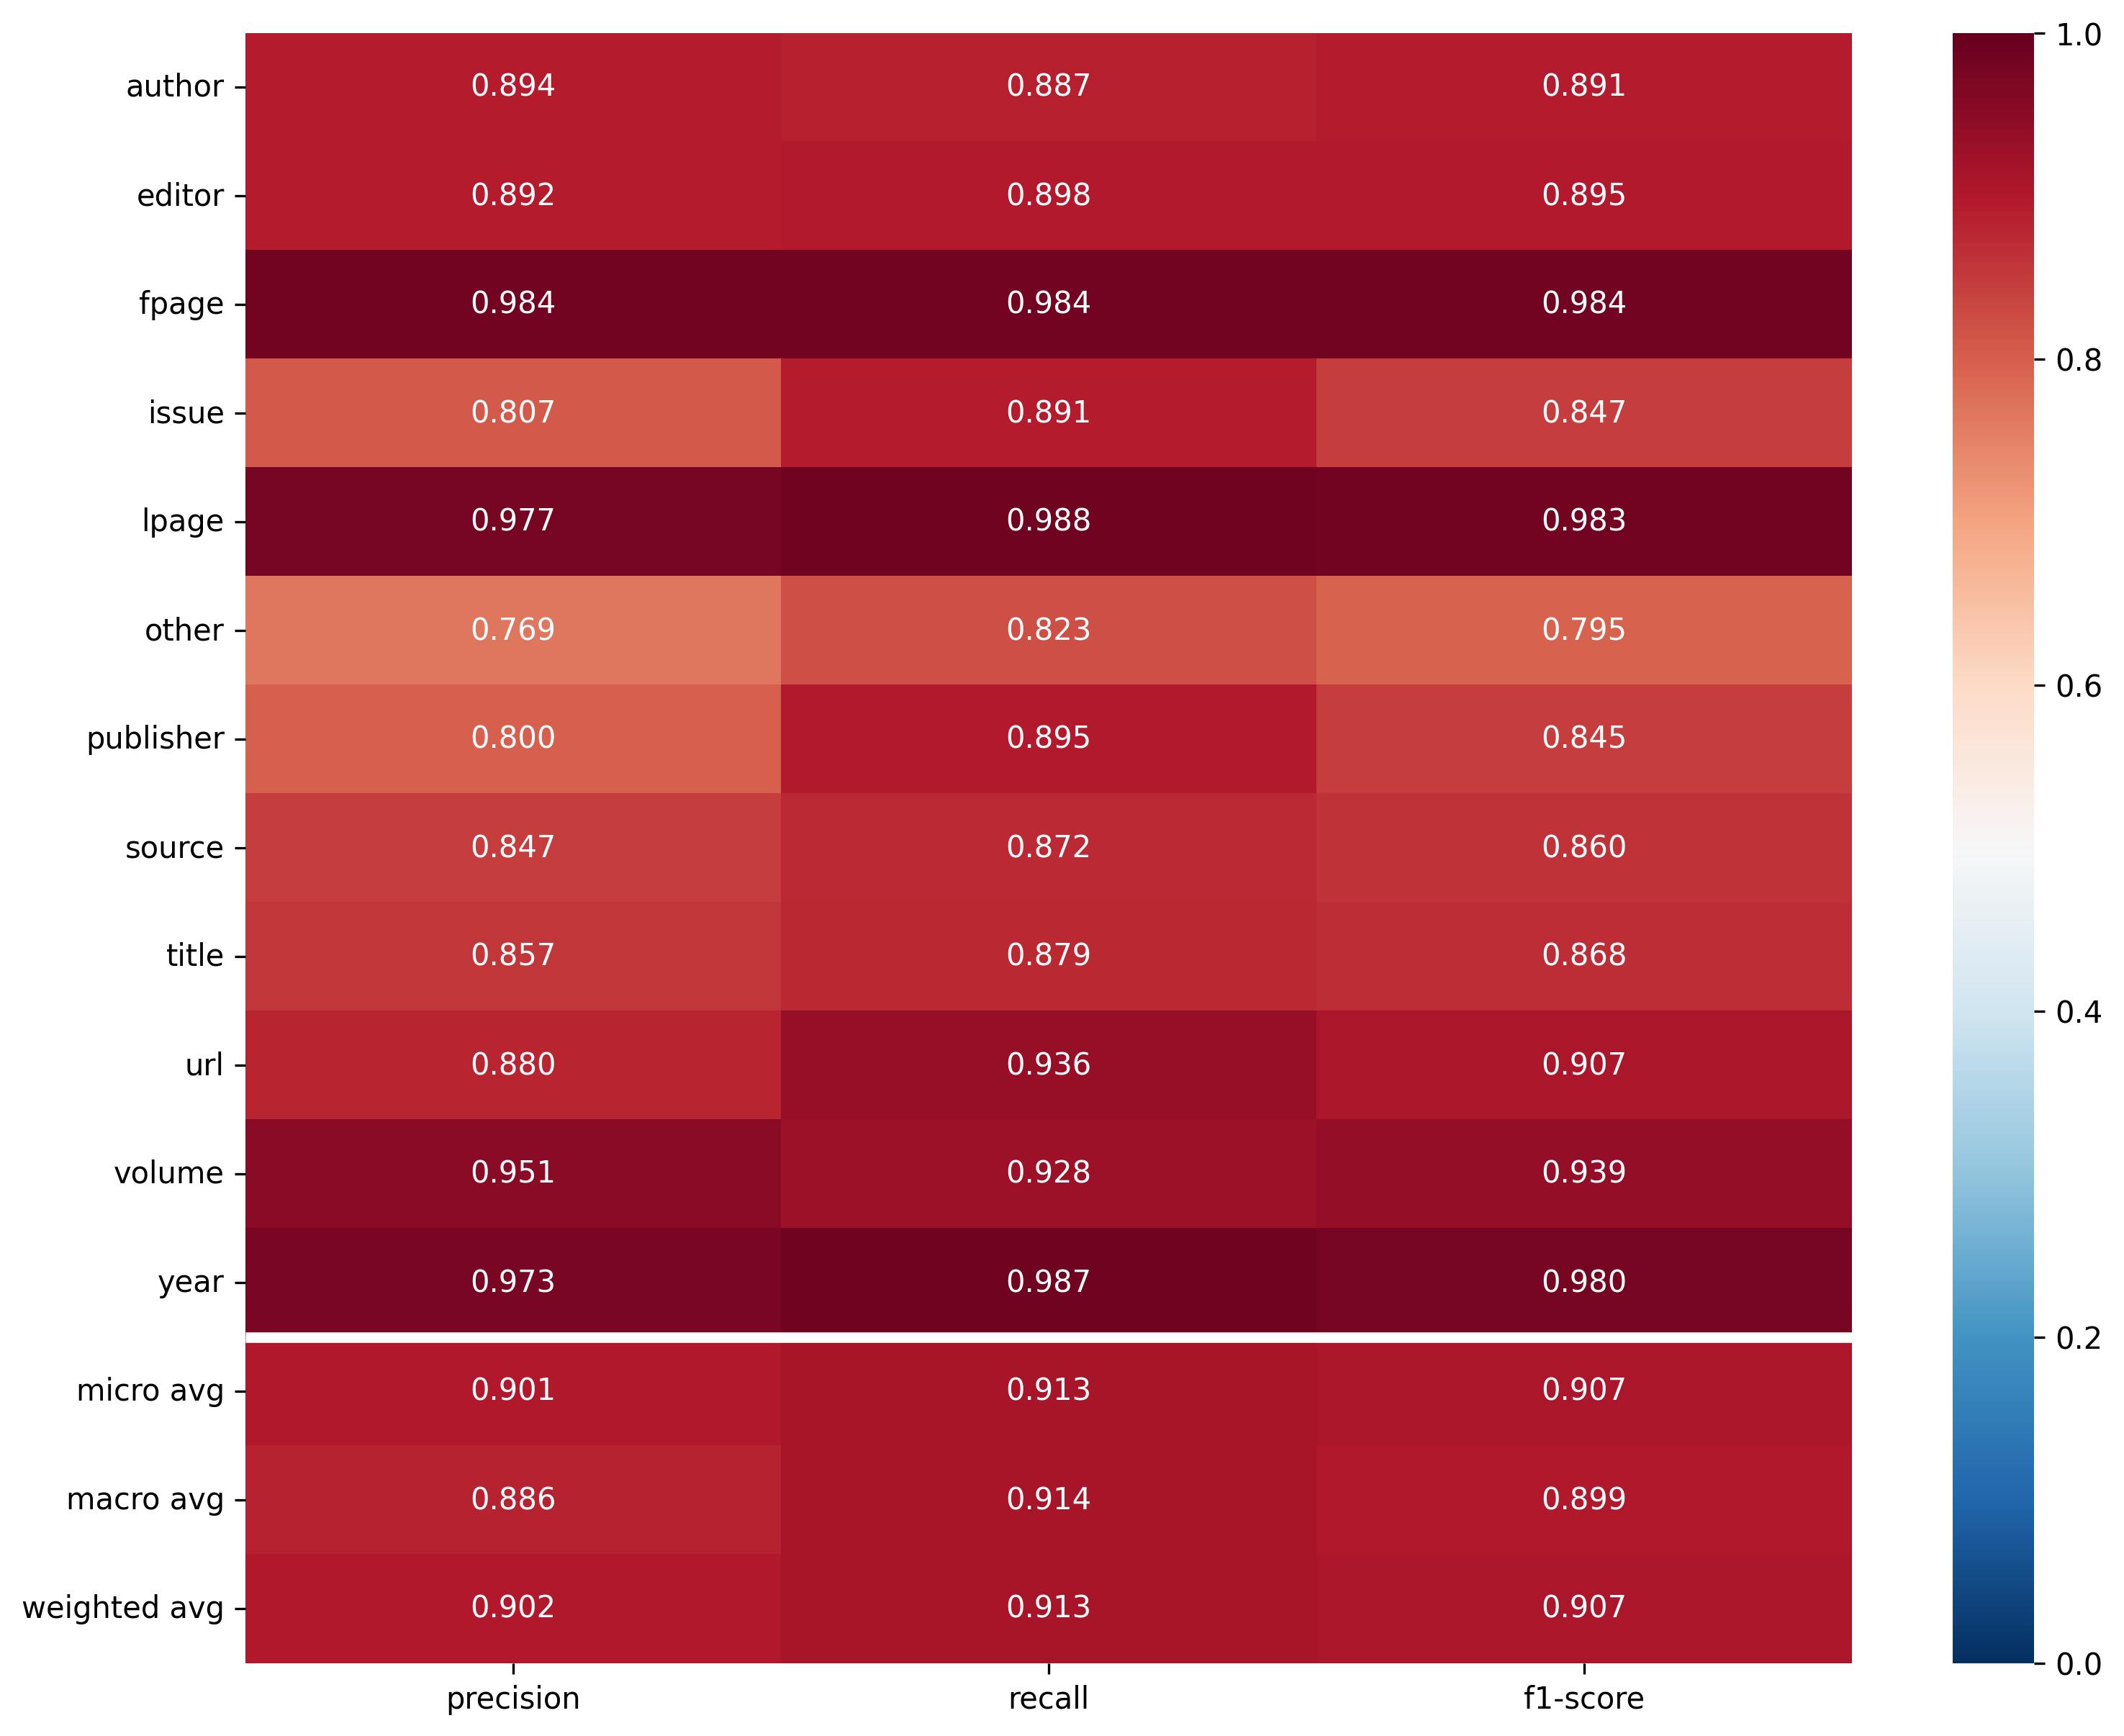

In [ ]:
report = classification_report(seg[0], seg[1], output_dict=True)
df_cr = pd.DataFrame(report)
fig, ax = plt.subplots(figsize=(12,10), dpi=300)
sns.heatmap(df_cr.iloc[:-1, :].T, annot=True, fmt=".3f", cmap= 'RdBu_r', vmin=0, vmax=1, ax=ax )
ax.hlines([len(labels)-1], *ax.get_xlim(), colors="white", linewidths = 3.5)
#print(f"Plotting evaluation for '{key}'.")
fig.show()
fig.savefig("ref_seg_xlm_roberta-large_" + "cls_report"+ ".png")

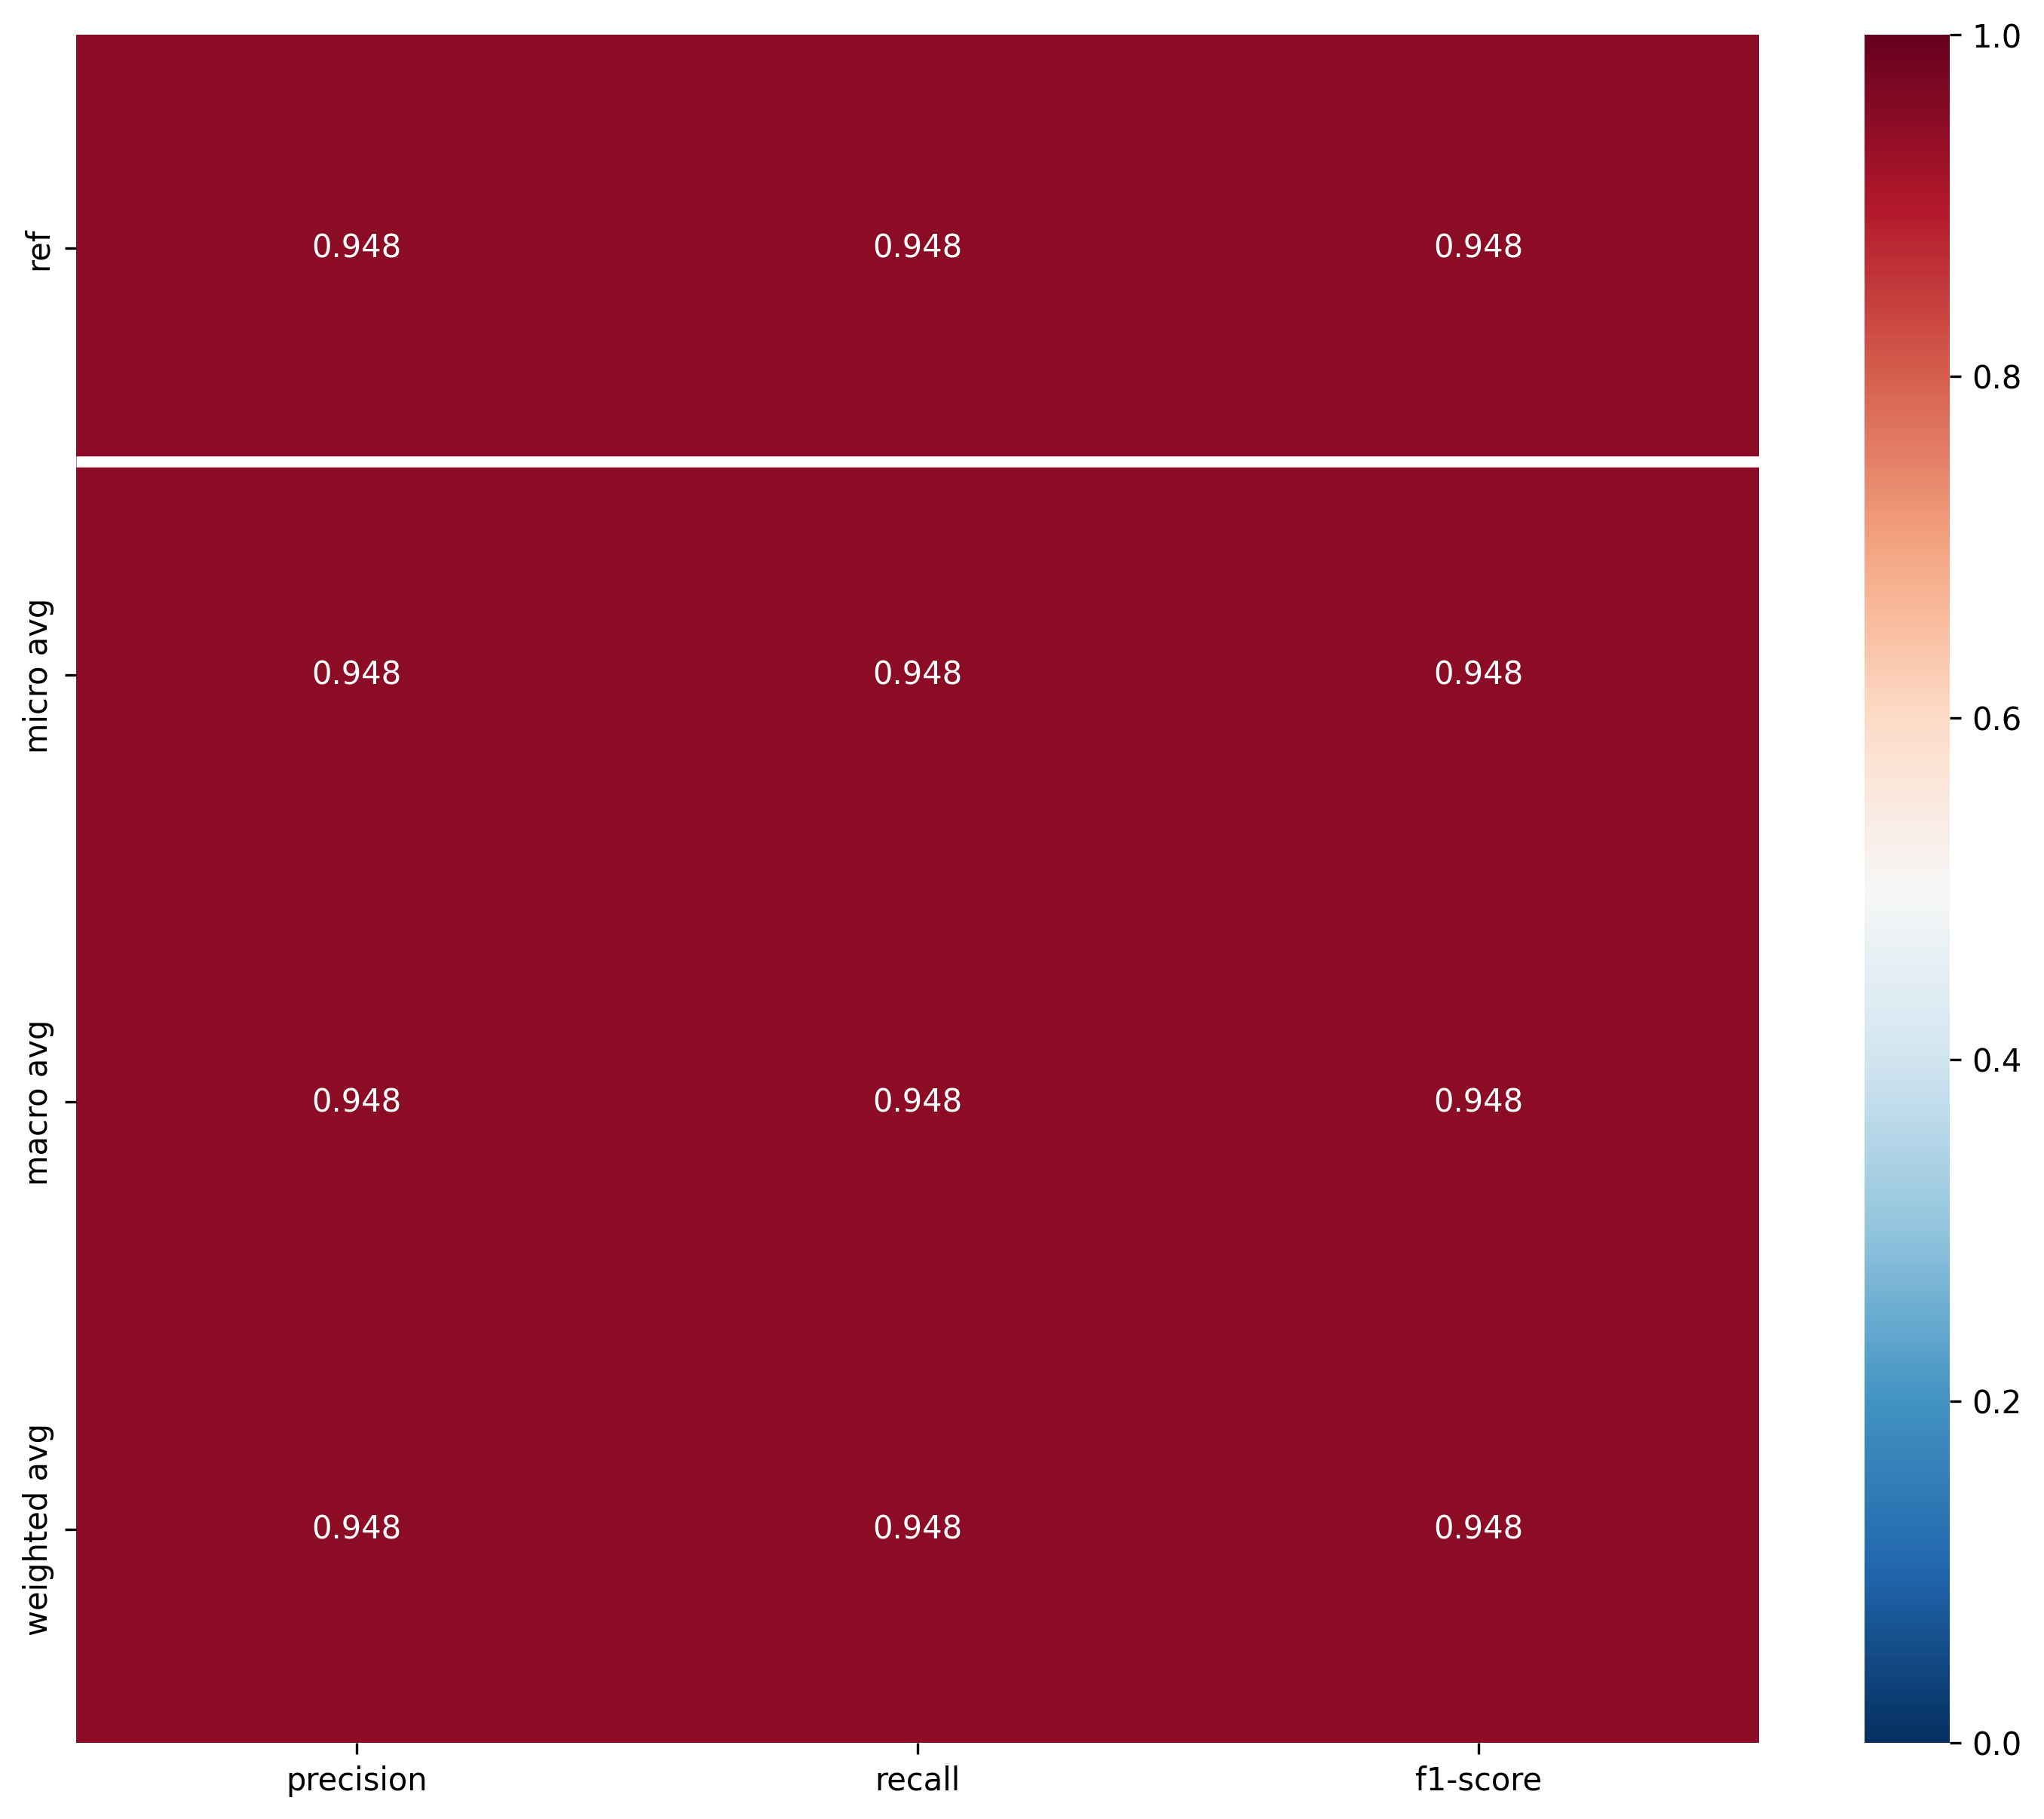

In [ ]:
report = classification_report(ref[0], ref[1], output_dict=True)
df_cr = pd.DataFrame(report)
fig, ax = plt.subplots(figsize=(12,10), dpi=300)
sns.heatmap(df_cr.iloc[:-1, :].T, annot=True, fmt=".3f", cmap= 'RdBu_r', vmin=0, vmax=1, ax=ax )
ax.hlines([1], *ax.get_xlim(), colors="white", linewidths = 3.5)
#print(f"Plotting evaluation for '{key}'.")
fig.show()
fig.savefig("ref_seg_ref_xlm_roberta-large_" + "cls_report"+ ".png")

In [ ]:
y_trues_label = [y for row in seg[0] for y in row]
y_preds_label = [y for row in seg[1] for y in row]

for norm in ["true", "pred"]:
    confusion_matrix = metrics.confusion_matrix(y_trues_label, y_preds_label, normalize=norm, labels=list(id2label.values()))
    df_cm = pd.DataFrame(confusion_matrix, index = id2label.values(),
                    columns = id2label.values())
    #plt.figure(figsize = (10,10))
    fig, ax = plt.subplots(figsize=(18,15), dpi=400)
    s = sns.heatmap(df_cm, annot=True, fmt=".2f", cmap= 'RdBu_r', ax=ax, vmin=0, vmax=1)
    s.set(xlabel='Predicted labels', ylabel='True labels')
    plt.yticks(rotation=0)
    plt.xticks(rotation=30)
    fig.show()
    fig.savefig(f"conf_matrix_xlm_roberta-large_norm_{norm}.png")

In [ ]:
model.push_to_hub("MrPotato/reference-segmentation-xlm-roberta-geocite-v2")

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/MrPotato/reference-segmentation-xlm-roberta-geocite-v2/commit/828557dd0700bff12cb4812a34907b826da21e67', commit_message='Upload XLMRobertaForReferenceSegmentation', commit_description='', oid='828557dd0700bff12cb4812a34907b826da21e67', pr_url=None, pr_revision=None, pr_num=None)

#Legacy Code

In [ ]:
s1 = "Veröffentlicht von Bernt , D. in 1996 : Berg und Tal - Strukturprobleme im Tourismus, Raum , 22 : 10 - 13."
s2 = "Wimmer H. (1985), Zur Ausländerbeschäftigungspolitik in Österreich. In: Wimmer H. (Hrsg.), Ausländische Arbeitskräfte in Österreich, S. 5-33. Frankfurt am Main."
s3 = 'D E GEER, E. H. (1953): La varve Zero et les drainages successifs finaux du grand lac de barrage Central du Jämtland. - Cahiers Geologiques 20, S. 171-184, Thoiry. - - (1957): Old an new datings of Swedish ice lakes. - GFF 79, S. 93-100.'
s4 = 'Kayser, K., W. Manshabd, H. Mensching, J. H. Schultze: Das Afrika-Kartenwerk. Ein Schwerpunktprogramm der Deutschen Forschungsgemeinschaft. Die Erde 97 (1966), S. 85—95.'
s5 = 'H. Flohn, In München auf und Struktur des ostasiatischen Sommermonsuns. Vortrag auf der Geographentagung 1948‚ im Druck (mit Karten, Diagrammen und zahlreichen Literaturangaben).'
s6 = 'Verband Deutscher Papierfabriken: Papier 83, Leistungsbericht der Papierindustrie, Bonn 1983.'

In [ ]:
nlp = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="first", device=0)

for d in nlp(s2):
    print(f"{d['entity_group']}: {d['word']}")

In [ ]:
# # Name of the BERT model to use
# model_name = 'xlm-roberta-base'

# # Max length of tokens
# max_length = 512

# # Load transformers config and set output_hidden_states to False
# config = XLMRobertaConfig.from_pretrained(model_name)
# config.output_hidden_states = False

# # Load BERT tokenizer
# tokenizer = XLMRobertaTokenizerFast.from_pretrained(model_name, config=config)

# # Load the Transformers BERT model
# transformer_model = TFXLMRobertaModel.from_pretrained(model_name, config = config)

In [ ]:
# def tokenize_and_align_labels(data):
#     tokenized_inputs = tokenizer(data["input_ids"],
#                                  truncation=True,
#                                  is_split_into_words=True,
#                                  padding='max_length',
#                                  max_length=512,
#                                  #return_tensors='tf',
#                                  )

#     labels = []
#     for i, label in enumerate(data[f"labels"]):
#         word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
#         previous_word_idx = None
#         label_ids = []
#         for word_idx in word_ids:  # Set the special tokens to -100.
#             if word_idx is None:
#                 label_ids.append(-100)
#             elif word_idx != previous_word_idx:  # Only label the first token of a given word.
#                 label_ids.append(label[word_idx])
#             else:
#                 label_ids.append(-100)
#             previous_word_idx = word_idx
#         labels.append(label_ids)

#     tokenized_inputs["labels"] = labels

#     labels_ref = []
#     for i, label in enumerate(data[f"labels_ref"]):
#         word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
#         previous_word_idx = None
#         label_ids = []
#         for word_idx in word_ids:  # Set the special tokens to -100.
#             if word_idx is None:
#                 label_ids.append(-100)
#             elif word_idx != previous_word_idx:  # Only label the first token of a given word.
#                 label_ids.append(label[word_idx])
#             else:
#                 label_ids.append(-100)
#             previous_word_idx = word_idx
#         labels_ref.append(label_ids)

#     tokenized_inputs["labels_ref"] = labels_ref

#     return tokenized_inputs

In [ ]:
# tokenized_train = dataset['train'].map(tokenize_and_align_labels, batched=True)
# tokenized_test = dataset['test'].map(tokenize_and_align_labels, batched=True)

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
# id2label = {k:v for k,v in enumerate(tokenized_train.features['labels'].feature.names)}
# label2id = {v:k for k,v in enumerate(tokenized_train.features['labels'].feature.names)}
# id2label_ref = {k:v for k,v in enumerate(tokenized_train.features['labels_ref'].feature.names)}
# label_ref2id = {v:k for k,v in enumerate(tokenized_train.features['labels_ref'].feature.names)}

In [ ]:
# TF Keras documentation: https://www.tensorflow.org/api_docs/python/tf/keras/Model

# Load the MainLayer
xml_r = transformer_model.layers[0]

# Build your model input
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
#attention_mask = Input(shape=(max_length,), name='attention_mask', dtype='int32')
# inputs = {'input_ids': input_ids, 'attention_mask': attention_mask}
inputs = {'input_ids': input_ids}

# Load the Transformers BERT model as a layer in a Keras model
xml_r_model = xml_r(inputs)[1]
dropout = Dropout(config.hidden_dropout_prob, name='pooled_output')
pooled_output = dropout(xml_r_model, training=False)

# Then build your model output
label = Dense(units=len(id2label), kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='seg')(pooled_output)
ref = Dense(units=len(id2label_ref), kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='ref')(pooled_output)
outputs = {'seg': label, 'ref': ref}

# And combine it all in a model object
model = Model(inputs=inputs, outputs=outputs, name='XML_R_MultiLabel_MultiClass')

# Take a look at the model
model.summary()

Model: "XML_R_MultiLabel_MultiClass"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 roberta (TFRobertaMainLayer)   TFBaseModelOutputWi  278043648   ['input_ids[0][0]']              
                                thPoolingAndCrossAt                                               
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                               
                                 768),                                                            
                                 pooler_output=(Non                     

In [ ]:
from transformers import TFAutoModelForTokenClassification

model_test = TFAutoModelForTokenClassification.from_pretrained(
    "xlm-roberta-base", num_labels=len(id2label), id2label=id2label, label2id=label2id
)
model_test.summary()

All model checkpoint layers were used when initializing TFXLMRobertaForTokenClassification.

Some layers of TFXLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tfxlm_roberta_for_token_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLayer  multiple                 277453056 
 )                                                               
                                                                 
 dropout_186 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  22301     
                                                                 
Total params: 277,475,357
Trainable params: 277,475,357
Non-trainable params: 0
_________________________________________________________________


In [ ]:
xml_r_model

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'bert')>

In [ ]:
# Set an optimizer
optimizer = Adam(
    learning_rate=1e-05,
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

# Set loss and metrics
loss = {'seg': SparseCategoricalCrossentropy(from_logits = True), 'ref': SparseCategoricalCrossentropy(from_logits = True)}
metric = {'seg': SparseCategoricalAccuracy('accuracy'), 'ref': SparseCategoricalAccuracy('accuracy')}

# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss,
    metrics = metric)

# Ready output data for the model
y_train_seg = tokenized_train['labels']
y_train_ref = tokenized_train['labels_ref']

# x = tf.convert_to_tensor(tokenized_train['input_ids'])

# Tokenize the input (takes some time)
# x = tokenizer(
#     text=dataset['train']['input_ids'],
#     add_special_tokens=True,
#     max_length=max_length,
#     truncation=True,
#     padding=True,
#     return_tensors='tf',
#     return_token_type_ids = False,
#     return_attention_mask = True,
#     is_split_into_words=True,
#     verbose = True)

# Fit the model
history = model.fit(
    # x={'input_ids': x['input_ids'], 'attention_mask': x['attention_mask']},
    x={'input_ids': np.asarray(tokenized_train['input_ids'])},
    y={'seg': np.asarray(y_train_seg), 'ref': np.asarray(y_train_ref)},
    validation_split=0.1,
    batch_size=1,
    epochs=2)

In [ ]:
np.asarray(y_train_seg)

array([[-100,    8, -100, ..., -100, -100, -100],
       [-100,   21, -100, ..., -100, -100, -100],
       [-100,   21, -100, ..., -100, -100, -100],
       ...,
       [-100,    8, -100, ..., -100, -100, -100],
       [-100,   14,   28, ..., -100, -100, -100],
       [-100,    8, -100, ..., -100, -100, -100]])

In [ ]:
dataset['train']['input_ids']

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import tensorflow as tf
tf.convert_to_tensor(tokenized_train['input_ids'])

<tf.Tensor: shape=(2489, 512), dtype=int32, numpy=
array([[     0,     62,  83752, ...,      1,      1,      1],
       [     0,  25124,   2658, ...,      1,      1,      1],
       [     0,     98,     70, ...,      1,      1,      1],
       ...,
       [     0,    159, 101811, ...,      1,      1,      1],
       [     0,     20,   1372, ...,      1,      1,      1],
       [     0,  81004,   1659, ...,      1,      1,      1]], dtype=int32)>

In [ ]:
# inputs = training_set[2]
# input_ids = inputs["input_ids"].unsqueeze(0)
# attention_mask = inputs["attention_mask"].unsqueeze(0)
# labels = inputs["labels"].unsqueeze(0)

# input_ids = input_ids.to(device)
# attention_mask = attention_mask.to(device)
# labels = labels.to(device)

# output = model(input_ids, attention_mask=attention_mask, labels_first=labels)

In [ ]:
# import gc
# del model
# torch.cuda.empty_cache()
# gc.collect()

328

In [ ]:
# output

[TokenClassifierOutput(loss=None, logits=tensor([[[ 0.2323,  0.2205, -0.5760,  ..., -0.0711,  0.1278,  0.2824],
          [ 0.1962,  0.2899, -0.4344,  ...,  0.0333, -0.1210,  0.4419],
          [ 0.2367,  0.4057, -0.3579,  ...,  0.1251, -0.0467,  0.4475],
          ...,
          [ 0.2753,  0.2005, -0.5403,  ..., -0.0341,  0.1653,  0.1767],
          [ 0.2753,  0.2005, -0.5403,  ..., -0.0341,  0.1653,  0.1767],
          [ 0.2753,  0.2005, -0.5403,  ..., -0.0341,  0.1653,  0.1767]]],
        device='cuda:0', grad_fn=<ViewBackward0>), hidden_states=None, attentions=None),
 TokenClassifierOutput(loss=None, logits=tensor([[[-0.0641,  0.1362,  0.5633],
          [-0.0158,  0.1754,  0.4524],
          [ 0.0266,  0.2352,  0.4552],
          ...,
          [-0.0583,  0.0732,  0.5265],
          [-0.0583,  0.0732,  0.5265],
          [-0.0583,  0.0732,  0.5265]]], device='cuda:0',
        grad_fn=<ViewBackward0>), hidden_states=None, attentions=None)]

In [ ]:
from tokenizers.pre_tokenizers import Whitespace
from transformers import pipeline

sentence = """
Zöller, L., Stremme, H.E. & Wagner, G.A. (1988): Thermolumineszenz-Datierung an Löß-Palä- oboden-Sequenzen von Nieder-, Mittel- und Oberrhein. - Chemical Geology (Isot. Geosc. Sect.), 73: 39-62; Heidelberg.
Zöller, L., Rousseau, D.-D., Jäger, K.-D. & Kukla, G. (2004): Last interglacial, Lower and Middle Weichselian - a comparative study from the Upper Rhine and Thuringian loess areas. - Zeitschrift Geomorphologie Neue Folge, 48: 1-24; Stuttgart.
"""
tk = Whitespace()
tkn_list, offsets = zip(*tk.pre_tokenize_str(sentence))
inputs = tokenizer(list(tkn_list),
                    is_split_into_words=True,
                    return_offsets_mapping=True,
                    padding='max_length',
                    truncation=True,
                    max_length=MAX_LEN,
                    return_tensors="pt")

# move to gpu
ids = inputs["input_ids"].to(device)
mask = inputs["attention_mask"].to(device)
# forward pass
outputs = model(ids, attention_mask=mask)
logits_seg = outputs[0][0]
logits_ref = outputs[0][1]

predicted_label_classes_seg= logits_seg.argmax(-1)
predicted_label_classes_ref = logits_ref.argmax(-1)
#print(predicted_label_classes) # shape (batch_size * seq_len, num_labels)
#flattened_predictions = torch.argmax(logits, axis=1) # shape (batch_size*seq_len,) - predictions at the token level

predicted_labels_seg = [id2label[id] for id in predicted_label_classes_seg.squeeze().tolist()]
predicted_labels_ref = [id2label_ref[id] for id in predicted_label_classes_ref.squeeze().tolist()]
#print(predicted_labels)

for id, label_seg, label_ref in zip(inputs.input_ids.squeeze().tolist(), predicted_labels_seg, predicted_labels_ref):
  print(tokenizer.decode([id]), label_seg, label_ref)



tokens = tokenizer.convert_ids_to_tokens(ids.squeeze().tolist())
token_predictions = [id2label[i] for i in flattened_predictions.cpu().numpy()]
wp_preds = list(zip(tokens, token_predictions)) # list of tuples. Each tuple = (wordpiece, prediction)

#for id, label in zip(encoding.input_ids.squeeze().tolist(), predicted_labels):
#  print(tokenizer.decode([id]), label)

prediction = []
for token_pred, mapping in zip(wp_preds, inputs["offset_mapping"].squeeze().tolist()):
    print(token_pred, mapping)
  #only predictions on first word pieces are important
    if mapping[0] == 0 and mapping[1] != 0:
     prediction.append(token_pred[1])
    else:
     continue

#list(zip(list(tkn_list), prediction))

<s> I-title I-ref
Z B-author B-ref
öl B-author B-ref
ler I-author I-ref
 I-author I-ref
, I-author I-ref
L I-author I-ref
 O I-ref
. O I-ref
, O I-ref
Stre B-author I-ref
mme B-author I-ref
 I-author I-ref
, I-author I-ref
H I-author I-ref
 I-author I-ref
. I-author I-ref
E I-author I-ref
 I-author I-ref
. I-author I-ref
& O I-ref
Wagner B-author I-ref
 I-author I-ref
, I-author I-ref
G I-author I-ref
 I-author I-ref
. I-author I-ref
A I-author I-ref
 I-author I-ref
. I-author I-ref
( O I-ref
1988 B-year I-ref
 O I-ref
): O I-ref
Thermo B-title I-ref
lum I-title I-ref
ines I-title I-ref
zen I-title I-ref
z I-title I-ref
- I-title I-ref
Dat I-title I-ref
ierung I-title I-ref
an I-title I-ref
Lö I-title I-ref
ß I-title I-ref
- I-title I-ref
Pa I-title I-ref
lä I-title I-ref
- I-title I-ref
o I-title I-ref
boden I-title I-ref
- I-title I-ref
Se I-title I-ref
quen I-title I-ref
zen I-title I-ref
von I-title I-ref
Nieder I-title I-ref
- I-title I-ref
, I-title I-ref
Mittel I-title I-ref
- I

NameError: ignored